# Multiwell Productivity Index

The MPI approach can be used to calculate gains from injectors to producers. There are a few assumptions:

1. The reservoir is rectangular
1. Permeability and porosity are roughly homogenous
1. Flow is semi-steady state (streamlines aren't moving too much)

Given the paucity of rectangular, homogenous reservoirs, why use this? Well, because CRM can have a very large parameter space, and this is a good first guess.

For an example, let's work with an 5x4 pattern with 5 injectors and 4 producers set on a grid. This is an example from the [Kaviani and Valko paper](https://doi.org/10.1016/j.petrol.2010.05.006) laying out the multiwell productivity index for waterfloods.

First, a few imports:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pywaterflood.multiwellproductivity import calc_gains_homogeneous

Now, set locations and make them into a dataframe.


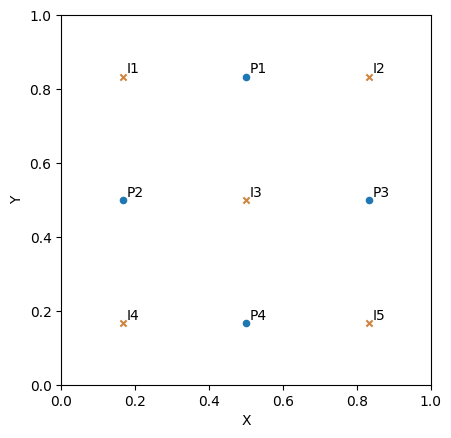

In [2]:
locations = pd.concat(
    [
        pd.DataFrame({"X": [1, 5, 3, 1, 5], "Y": [5, 5, 3, 1, 1], "Type": "Injector"}),
        pd.DataFrame({"X": [3, 1, 5, 3], "Y": [5, 3, 3, 1], "Type": "Producer"}),
    ]
)
locations.index = [f"I{i+1}" for i in range(5)] + [f"P{i+1}" for i in range(4)]
locations["X"] /= 6
locations["Y"] /= 6
fig, ax = plt.subplots()
locations[locations.Type == "Producer"].plot.scatter(x="X", y="Y", ax=ax, label="Producer")
locations[locations.Type == "Injector"].plot.scatter(
    x="X", y="Y", color="peru", marker="x", ax=ax, label="Injector"
)
ax.set(xlim=(0, 1), ylim=(0, 1), aspect=1)
ax.get_legend().remove()
for i, label in enumerate(locations.index):
    xy = locations.iloc[i][["X", "Y"]] + 0.01
    ax.annotate(label, xy)

Now we can calculate the influence of each injector on each producer:


[Text(0.5, 23.52222222222222, 'Injector'),
 Text(50.722222222222214, 0.5, 'Producer')]

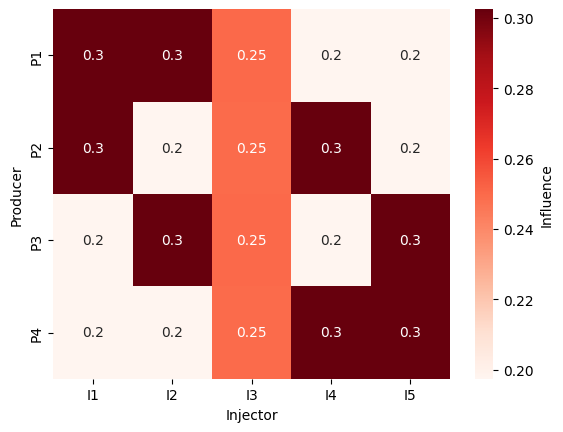

In [3]:
mpi_connectivity = -calc_gains_homogeneous(locations, x_e=1.0, y_e=1.0)
g = sns.heatmap(mpi_connectivity, annot=True, cmap="Reds", cbar_kws={"label": "Influence"})
g.set(xlabel="Injector", ylabel="Producer")

And feed the influences in as initial guesses for CRM:


In [4]:
from pywaterflood import CRM

# set initial guess at gains, subject to limits
gain_guess = mpi_connectivity.copy().to_numpy()
gain_guess[gain_guess >= 1] = 0.99
gain_guess[gain_guess < 1e-4] = 1e-4

# Get time-rate data
gh_url = "https://raw.githubusercontent.com/frank1010111/pywaterflood/master/testing/data/"
prod = pd.read_csv(gh_url + "production.csv", header=None)
inj = pd.read_csv(gh_url + "injection.csv", header=None)
time = pd.read_csv(gh_url + "time.csv", header=None)
n_inj = inj.shape[1]


crm = CRM(primary=True, constraints="up-to one")
crm.set_rates(prod.values, inj.values, time.values[:, 0])
old_guess = crm._get_initial_guess()
new_guess = [np.concatenate([gg, fg[n_inj:]]) for gg, fg in zip(gain_guess, old_guess)]
crm.fit(
    prod.values,
    inj.values,
    time.values[:, 0],
    initial_guess=new_guess,
    num_cores=4,
)

And see how the CRM connectivity results look


<Axes: xlabel='Injectors', ylabel='Producers'>

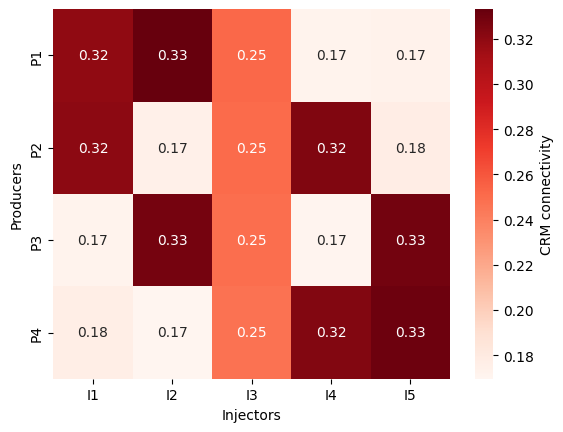

In [5]:
sns.heatmap(
    pd.DataFrame(crm.gains, index=mpi_connectivity.index, columns=mpi_connectivity.columns),
    annot=True,
    cbar_kws={"label": "CRM connectivity"},
    cmap="Reds",
)

This is quite close to the theory provided by the MPI.
